In [30]:
import gym
import numpy as np
from itertools import count
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical

gamma = 0.95
seed = 543
render = False
log_interval = 10

env = gym.make('CartPole-v0')
# env._max_episode_steps = 1000
env.seed(seed)
torch.manual_seed(seed)


class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.linear1 = nn.Linear(4, 256)
        self.linear2 = nn.Linear(256, 2)

        self.saved_log_probs = []
        self.rewards = []

    def forward(self, x):
        x = F.relu(self.linear1(x))
        action_scores = self.linear2(x)
        return F.softmax(action_scores, dim=1)


policy = Policy()
optimizer = optim.Adam(policy.parameters(), lr=1e-2)
eps = np.finfo(np.float32).eps.item()
rew_ep = []

def select_action(state):
    state = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state)
    m = Categorical(probs)
    action = m.sample()
    policy.saved_log_probs.append(m.log_prob(action))
    return action.item()


def finish_episode(b):
    R = 0
    policy_loss = []
    rewards = []
    for r in policy.rewards[::-1]:
        R = r + gamma * R
        rewards.insert(0, R)
    rewards = torch.tensor(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + eps)
#     print(rewards)
    for log_prob, reward in zip(policy.saved_log_probs, rewards):
        policy_loss.append(-log_prob * (reward))
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()
    del policy.rewards[:]
    del policy.saved_log_probs[:]


def main():
    running_reward = 0
    b = 0
    for i_episode in range(10000):
        tot_rew = 0
        state = env.reset()
        done = False
        while not done:
            action = select_action(state)
            state, reward, done, _ = env.step(action)
            if render:
                env.render()
            policy.rewards.append(reward)
            tot_rew += reward
            if done:
                break
        rew_ep.append(tot_rew)
        running_reward = running_reward * 0.99 + tot_rew * 0.01
        b += (tot_rew-b)/(i_episode+1)
        finish_episode(b)
        if i_episode % log_interval == 0:
            print('Episode {}\tLast Reward: {:2f}\tAverage Reward: {:.2f}'.format(
                i_episode, tot_rew, running_reward))
        if running_reward > env.spec.reward_threshold:
            print("Solved! Running reward is now {} and "
                  "the last episode gives {} !".format(running_reward, tot_rew))
            break

In [31]:
main()

Episode 0	Last Reward: 11.000000	Average Reward: 0.11
Episode 10	Last Reward: 26.000000	Average Reward: 4.57
Episode 20	Last Reward: 175.000000	Average Reward: 12.60
Episode 30	Last Reward: 29.000000	Average Reward: 15.30
Episode 40	Last Reward: 46.000000	Average Reward: 17.81
Episode 50	Last Reward: 200.000000	Average Reward: 26.76
Episode 60	Last Reward: 108.000000	Average Reward: 34.61
Episode 70	Last Reward: 150.000000	Average Reward: 40.79
Episode 80	Last Reward: 200.000000	Average Reward: 49.79
Episode 90	Last Reward: 200.000000	Average Reward: 63.85
Episode 100	Last Reward: 164.000000	Average Reward: 74.38
Episode 110	Last Reward: 110.000000	Average Reward: 79.95
Episode 120	Last Reward: 200.000000	Average Reward: 89.47
Episode 130	Last Reward: 200.000000	Average Reward: 100.04
Episode 140	Last Reward: 200.000000	Average Reward: 109.09
Episode 150	Last Reward: 200.000000	Average Reward: 117.78
Episode 160	Last Reward: 12.000000	Average Reward: 114.09
Episode 170	Last Reward: 24.

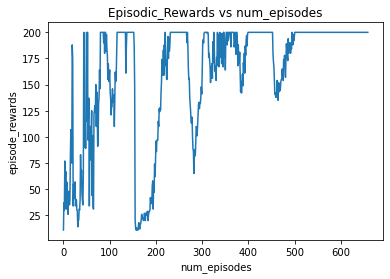

In [34]:
plt.plot(rew_ep)
plt.xlabel('num_episodes')
plt.ylabel('episode_rewards')
plt.title('Episodic_Rewards vs num_episodes')

plt.savefig('reinforce_b_cartpole')

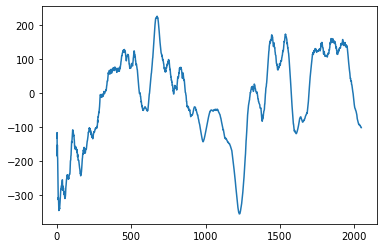

In [28]:
mean_rewards = []
for t in range(len(rew_ep)):
        mean_rewards.append(np.mean(rew_ep[max(0, t-50):(t+1)]))
plt.plot(mean_rewards)
plt.show()